In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scienceplots
import seaborn as sns
import networkx as nx
from nanonets import Simulation
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
from scipy.optimize import curve_fit
from scipy.special import gamma
from scipy.linalg import eig

plt.style.use(["science","bright","grid"])

CPU_CNT     = 32
N_VOLT      = 50000
TIME_STEP   = 1e-11
R_VALUES    = [50,100,200,400,800,1600]
PLOT_NORM_R = Normalize(vmin=R_VALUES[0], vmax=R_VALUES[-1])
CMAP        = plt.get_cmap('cividis')
U0_VALUE    = 0.02
N_P         = 9
N_J_TOTAL   = 2*N_P*(N_P-1)
MARKERS     = ['o','s','<','>','^']
# FOLDER      = "/home/j/j_mens07/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/res_disorder/"
# FOLDER      = "/home/j/j_mens07/phd/data/2_funding_period/dynamic/DC/res_disorder/"
FOLDER      = "/home/jonasmensing/bagheera/data/2_funding_period/dynamic/DC/res_disorder/"

def tau_exp_fit(t, y, min_range=0.05, kohlrausch=True):
    signal_range = np.max(y) - np.min(y)
    if signal_range < min_range:
        return np.nan
    
    t_ns    = t * 1e9
    y_start = y[0]
    y_end   = np.median(y[int(len(y)*0.9):])
    A_fixed = y_end - y_start
    th_val  = y_start + 0.632 * A_fixed

    if A_fixed > 0:
        cross_idx = np.where(y > th_val)[0]
    else:
        cross_idx = np.where(y < th_val)[0]

    if len(cross_idx) > 0:
        guess_tau = t_ns[cross_idx[0]]
    else:
        guess_tau = 0.1

    if kohlrausch:
        def relaxation_model(t_vals, tau, beta):
            return y_start + A_fixed * (1 - np.exp(-(t_vals / tau)**beta))
        p0 = [guess_tau, 1.0]
        bounds = ([1e-6, 0.1], [np.inf, 1.0])
    else:
        def relaxation_model(t_vals, tau):
            return y_start + A_fixed * (1 - np.exp(-t_vals / tau))
        p0 = [guess_tau]
        bounds = (1e-6, np.inf)

    try:
        popt, pcov = curve_fit(relaxation_model, t_ns, y, p0=p0, bounds=bounds)
        if kohlrausch:
            tau_k   = popt[0]
            beta    = popt[1]
            tau_fit = (tau_k / beta) * gamma(1 / beta)
        else:
            tau_fit = popt[0]
        return tau_fit * 1e-9, beta
    except RuntimeError:
        return np.nan, np.nan

/home/jonasmensing/.local/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


### Load Average Potential Data

In [2]:
t       = np.arange(N_VOLT) * TIME_STEP
p_vals  = {MEAN_R2 : [pd.read_csv(f"{FOLDER}mean_state_Nx={N_P}_Ny={N_P}_Ne=8_mean2_{MEAN_R2}_{i}.csv").iloc[:,8:].values 
                        for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}
p_avg   = {MEAN_R2 : [np.mean(p_vals[MEAN_R2][i], axis=1) for i in range(CPU_CNT)] for MEAN_R2 in R_VALUES}

### RC Time Constant

In [3]:
tau_t = {}
for MEAN_R2 in R_VALUES:
    tau_t_l     = []
    res_info2   = {'N':N_J_TOTAL//3, 'mean_R':MEAN_R2, 'std_R':0.0}
    for i in range(CPU_CNT):
        topo = {"Nx": N_P,"Ny": N_P,
                        "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                                [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                                [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
                        "electrode_type": ['constant']*8}
        sim_c   = Simulation(topo, seed=i, res_info2=res_info2)
        sim_c.build_conductance_matrix()
        cap_m           = sim_c.get_capacitance_matrix()*1e-18
        g_m             = sim_c.get_conductance_matrix()[:-8,:-8]
        eigenvalues, _  = eig(g_m, cap_m)
        real_eigs       = np.real(eigenvalues)
        valid_eigs      = real_eigs[real_eigs > 1e-9]
        lambda_min      = np.min(valid_eigs)
        tau_t_l.append(1.0 / lambda_min)
    tau_t[MEAN_R2] = tau_t_l
df_taus_t           = pd.DataFrame(tau_t)*1e9
df_taus_t.columns   = R_VALUES
df_taus_t['Type']   = '$\\tau_0$'
df_taus_t.head()

,50,100,200,400,800,1600,Type
0,4.042302,5.258142,6.991133,9.273136,11.922206,18.611287,$\tau_0$
1,3.877868,4.956339,6.623981,8.886881,12.062466,22.113700,$\tau_0$
2,3.805405,4.680217,6.228277,8.726023,12.208351,21.934758,$\tau_0$
3,4.031063,5.290445,7.023739,9.486242,15.364476,29.262853,$\tau_0$
4,3.885222,4.807061,6.015660,7.355621,10.699304,20.244644,$\tau_0$


### Average Time Constant

In [4]:
kohlrausch  = True
taus_d      = {}
betas_d     = {}
for MEAN_R2 in R_VALUES:
    taus    = []
    betas   = []
    for i in range(CPU_CNT):
        t_copy      = t.copy()[:-1]
        y_copy      = (p_avg[MEAN_R2][i].copy())/U0_VALUE
        tau, beta   = tau_exp_fit(t_copy, y_copy, kohlrausch=kohlrausch)
        taus.append(tau*1e9)
        betas.append(beta)
    taus_d[MEAN_R2]     = taus
    betas_d[MEAN_R2]    = betas
df_taus         = pd.DataFrame(taus_d)
df_taus.columns = R_VALUES
df_taus['Type'] = '$\\langle \\tau \\rangle$'
df_taus         = pd.concat([df_taus, df_taus_t], ignore_index=True)
df_tau_melted   = df_taus.melt(id_vars='Type', var_name='$R_2$ [M$\Omega$]', value_name='t')
df_taus.head()

,50,100,200,400,800,1600,Type
0,4.691282,4.908226,5.569597,5.340558,4.673830,4.287065,$\langle \tau \rangle$
1,4.781192,5.270015,5.710424,7.253406,7.400782,9.022100,$\langle \tau \rangle$
2,4.859652,5.022288,5.509415,6.146706,7.182687,8.821105,$\langle \tau \rangle$
3,4.567568,5.053514,4.996153,5.022381,4.794694,5.011146,$\langle \tau \rangle$
4,5.235981,5.819647,7.056475,9.265108,9.670593,11.168274,$\langle \tau \rangle$


In [15]:
np.sort(betas_d[1600])

array([0.47901687, 0.48837837, 0.50685511, 0.52518505, 0.54941067,
       0.55430646, 0.59645332, 0.6084022 , 0.61153361, 0.61838516,
       0.64187524, 0.67105974, 0.68023302, 0.68643254, 0.69061487,
       0.7074293 , 0.70946174, 0.71078235, 0.72133888, 0.72902017,
       0.73145007, 0.73481091, 0.74366899, 0.7987089 , 0.81255507,
       0.81333651, 0.81478248, 0.86671166, 0.8693385 , 0.89601491,
       0.94215207, 1.        ])

In [20]:
np.sort(betas_d[1600])

array([0.47901687, 0.48837837, 0.50685511, 0.52518505, 0.54941067,
       0.55430646, 0.59645332, 0.6084022 , 0.61153361, 0.61838516,
       0.64187524, 0.67105974, 0.68023302, 0.68643254, 0.69061487,
       0.7074293 , 0.70946174, 0.71078235, 0.72133888, 0.72902017,
       0.73145007, 0.73481091, 0.74366899, 0.7987089 , 0.81255507,
       0.81333651, 0.81478248, 0.86671166, 0.8693385 , 0.89601491,
       0.94215207, 1.        ])

In [5]:
df_uni_res = pd.DataFrame([['$\\langle \\tau \\rangle$','$\\tau_0$'],[25,25],[4.3696610612686255, 3.1943502805261783]],
                          index=['Type','$R_2$ [M$\Omega$]','t']).T
df_uni_res.iloc[0,1]

25

TypeError: can't get common type for non-numeric array

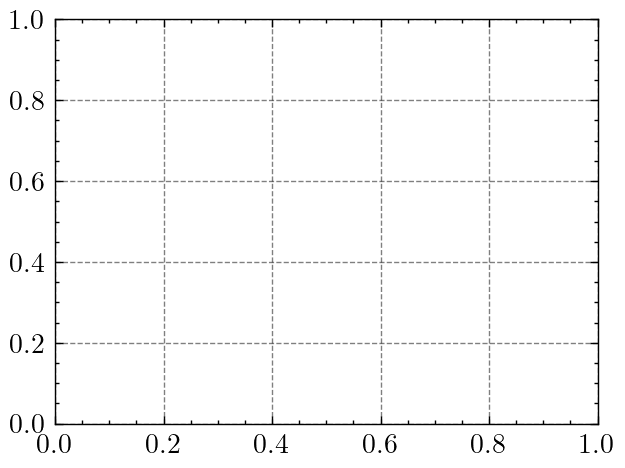

In [6]:
df      = pd.concat([df_tau_melted,df_uni_res],ignore_index=True)
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(df, x='$R_2$ [M$\Omega$]', y='t', hue='Type', density_norm='width', inner='stick', cut=0)
_       = ax.legend(title='')
# _       = ax.set_yscale('log')
_       = ax.set_ylabel("$\\tau$ [ns]")

# fig.savefig(f"plots/png/relaxation/tau_vs_R2.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/tau_vs_R2.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/tau_vs_R2.svg", transparent=True)

In [ ]:
print(np.argmax(betas_d[1600]))
print(betas_d[1600][np.argmax(betas_d[1600])])

20
0.8829039970659608


In [ ]:
print(np.argmin(betas_d[1600]))
print(betas_d[1600][np.argmin(betas_d[1600])])

15
0.5887901891537132


In [19]:
print(np.argmin(taus_d[1600]))
print(taus_d[1600][np.argmin(taus_d[1600])])

10
2.5475756770492834


In [ ]:
print(np.argmax(taus_d[1600]))
print(taus_d[1600][np.argmax(taus_d[1600])])

29
10.756889673049496


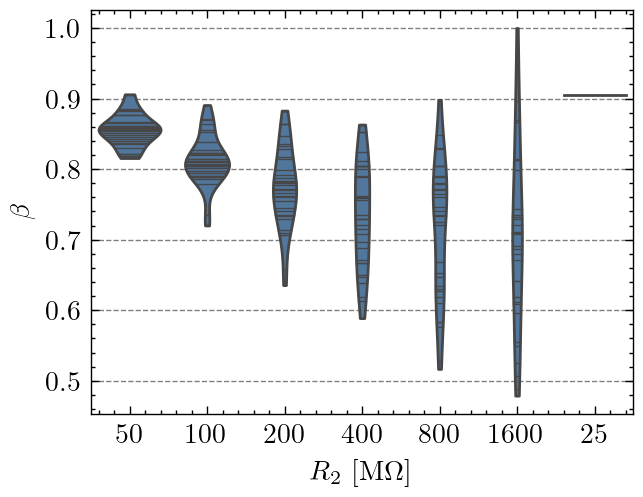

In [10]:
df      = pd.DataFrame(betas_d)
df[25]  = 0.9049540095671246
fig, ax = plt.subplots(dpi=200)
ax      = sns.violinplot(df, density_norm='width', inner='stick', cut=0, color='#4477AA')
_       = ax.set_xlabel("$R_2$ [M$\Omega$]")
_       = ax.set_ylabel("$\\beta$")

# fig.savefig(f"plots/png/relaxation/beta_vs_R2.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/beta_vs_R2.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/beta_vs_R2.svg", transparent=True)

### Conductance Matrix

In [292]:
def analyze_matrix_topology(G_mat, source_node=81, drain_node=88, R1_val=25e6):

    g_tmp = np.abs(G_mat.copy())
    np.fill_diagonal(g_tmp, 0.0)

    graph = nx.from_numpy_array(g_tmp)
    for u, v, data in graph.edges(data=True):
        g_val = data['weight']
        if g_val != 0:
            data['R'] = 1.0 / g_val
        else:
            data['R'] = np.inf
    G1_val = 1.0 / R1_val
    fast_edges = [
        (u, v) for u, v, d in graph.edges(data=True) 
        if d['weight'] >= G1_val * 0.99
    ]

    g_fast = nx.Graph()
    g_fast.add_nodes_from(graph)
    g_fast.add_edges_from(fast_edges)

    has_R1_path = nx.has_path(g_fast, source_node, drain_node)

    try:
        R_shortest = nx.shortest_path_length(
            graph, source=source_node, target=drain_node, weight='R'
        )
    except nx.NetworkXNoPath:
        R_shortest = np.nan

    try:
        R_eff = nx.resistance_distance(
            graph, source_node, drain_node, weight='weight'
        )
    except:
        R_eff = np.nan

    return {
        'has_R1_path': has_R1_path,
        'R_shortest': R_shortest,
        'R_eff': R_eff
    }

drains = [82,83,84,85,86,87,88]
topo_d = {}
for MEAN_R2 in R_VALUES:
    topo_l      = []
    res_info2   = {'N':N_J_TOTAL//3, 'mean_R':MEAN_R2, 'std_R':0.0}
    for i in range(CPU_CNT):
        topo = {"Nx": N_P,"Ny": N_P,
                        "e_pos": [[(N_P-1)//2, 0],[0, 0],[N_P-1, 0],
                                [0, (N_P-1)//2],[N_P-1, (N_P-1)//2],
                                [0, N_P-1],[N_P-1, N_P-1],[(N_P-1)//2, N_P-1]],
                        "electrode_type": ['constant']*8}
        sim_c   = Simulation(topo, seed=i, res_info2=res_info2)
        sim_c.build_conductance_matrix()
        g_m = sim_c.get_conductance_matrix()
        d_vals = []
        for d in drains:
            res = analyze_matrix_topology(g_m, drain_node=d)
            d_vals.append(res)
        topo_l.append(d_vals)
    topo_d[MEAN_R2] = topo_l

In [319]:
df_topo = pd.DataFrame()
for MEAN_R2 in R_VALUES:
    for i in range(CPU_CNT):
        df      = pd.DataFrame(topo_d[MEAN_R2][i]).reset_index()
        df['i'] = i
        df['t'] = taus_d[MEAN_R2][i]
        df['n'] = df['has_R1_path'].sum()
        df_topo = pd.concat([df_topo,df],ignore_index=True)

In [326]:
df

,index,has_R1_path,R_shortest,R_eff,i,t,n
0,0,False,1.775000e+09,9.342082e-08,31,5.925514,5
1,1,True,5.000000e+08,1.125299e-07,31,5.925514,5
2,2,True,2.500000e+08,9.890318e-08,31,5.925514,5
3,3,True,3.500000e+08,1.023462e-07,31,5.925514,5
4,4,True,3.500000e+08,1.309418e-07,31,5.925514,5
5,5,False,2.025000e+09,9.802741e-08,31,5.925514,5
6,6,True,5.000000e+08,1.067778e-07,31,5.925514,5


<Axes: xlabel='n', ylabel='t'>

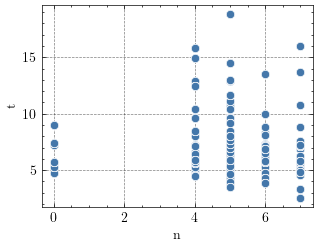

In [321]:
sns.scatterplot(df_topo, x='n', y='t')

---

In [35]:
kohlrausch  = True
taus_d_pp   = {}
for MEAN_R2 in R_VALUES:
    taus = []
    for i in range(CPU_CNT):
        taus_p = []
        for j in range(int(N_P*N_P)):
            t_copy  = t.copy()[:-1]
            y_copy  = (p_vals[MEAN_R2][i][:,j].copy())/U0_VALUE
            tau     = tau_exp_fit(t_copy, y_copy, kohlrausch=kohlrausch)
            taus_p.append(tau*1e9)
        taus.append(taus_p)
    taus_d_pp[MEAN_R2] = taus

In [74]:
df_taus_pp          = pd.DataFrame({R : np.array(taus_d_pp[R]).flatten() for R in R_VALUES})
# df_taus_pp.columns  = [f"$R = {R}$ M$\Oemga$" for R in R_VALUES]
df_taus_pp.head(5)

,50,100,200,400,800,1600
0,0.719129,0.734872,0.787487,0.861961,0.838929,0.905294
1,5.762264,5.064645,6.688505,6.788661,6.793348,8.252260
2,5.372422,5.093049,6.313431,6.517643,6.957923,8.291972
3,4.072070,4.093043,5.076107,5.378220,5.788968,7.307297
4,2.600638,2.674889,3.145126,3.573921,3.968846,4.691203


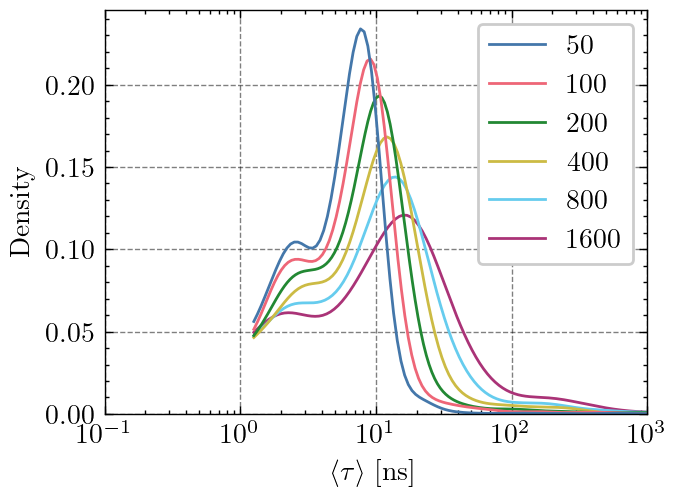

In [ ]:
fig, ax = plt.subplots(dpi=200)
ax      = sns.kdeplot(df_taus_pp, log_scale=True, cut=0, clip=(1e-1, 1e3), fill=)
_       = ax.set_xlim(1e-1, 1e3)
_       = ax.set_xlabel("$\\langle \\tau \\rangle$ [ns]")

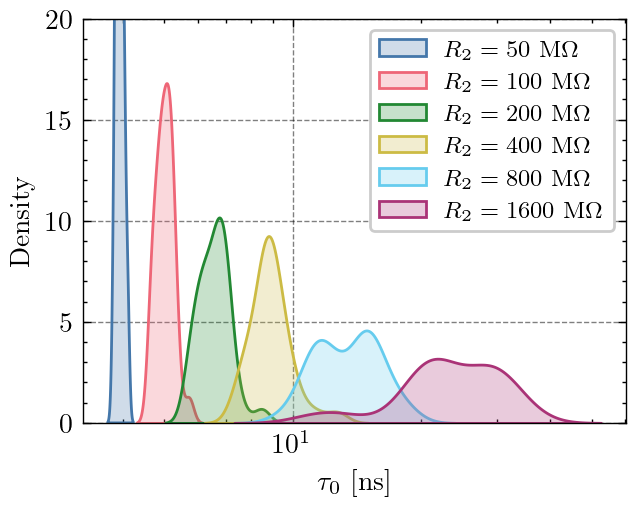

In [17]:
fig, ax = plt.subplots(dpi=200)
for mean_R2 in R_VALUES:
    t_vals  = np.array(tau_t[mean_R2].copy())*1e9
    ax      = sns.kdeplot(t_vals, cumulative=False, log_scale=True, fill=True, label=f'$R_2 = {mean_R2}$ M$\Omega$')
_ = ax.set_xlabel("$\\tau_0$ [ns]")
_ = ax.set_ylim(0,20)
_ = ax.legend(fontsize='small')

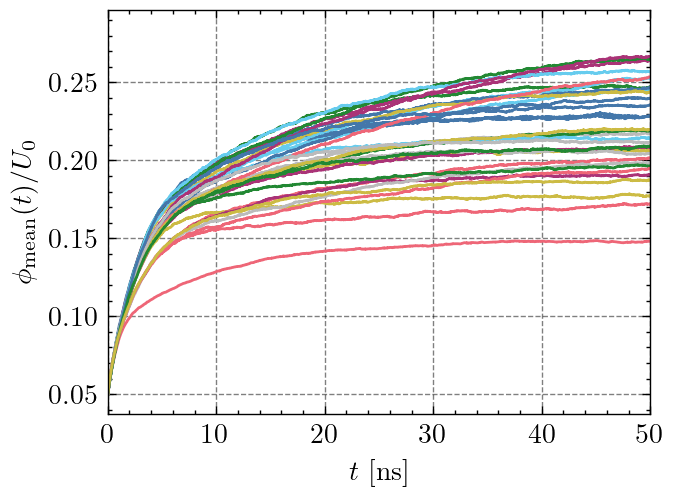

In [34]:
MEAN_R2 = 800
fig, ax = plt.subplots(dpi=200)
for i in range(CPU_CNT):
    t_copy  = t.copy()[:-1]*1e9
    y_copy  = (p[MEAN_R2][i].copy())/U0_VALUE
    ax.plot(t_copy, y_copy)
    
_ = ax.set_xlabel("$t$ [ns]")
_ = ax.set_ylabel("$\\phi_\mathrm{mean}(t)/U_0$")
_ = ax.set_xlim(0, 5000*TIME_STEP*1e9)

# fig.savefig(f"plots/png/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.png", transparent=False)
# fig.savefig(f"plots/pdf/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.pdf", transparent=False)
# fig.savefig(f"plots/svg/relaxation/N={N_NP}_N={N_NP}_pot_vs_t.svg", transparent=True)